In [238]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [239]:
pd.options.display.max_columns = 100

In [240]:
df = pd.read_csv('revo_ds_test_task.csv')

In [241]:
target = 'bad_flag'
trash_features = ['loanKey']
date_columns = ['rep_loan_date', 'first_loan', 'first_overdue_date']

In [242]:
def replace_not_popular_categories(df, column, threshold=0.03, val=-1):
    val_cal = df[column].value_counts()
    s = val_cal.sum()
    not_popular_cats = val_cal[val_cal < int(s*threshold)].index.values
    not_popular_indexes = df[df[column].isin(not_popular_cats)].index.values
    df.loc[not_popular_indexes, column] = val
    return df

In [243]:
for col in date_columns:
    df[col] = pd.to_datetime(df[col])
    df[col] = (df[col].dt.year-2015)*12 +df[col].dt.month
    df = replace_not_popular_categories(df, col)

In [244]:
df = replace_not_popular_categories(df, 'TraderKey')

In [245]:
df['federal_district_nm'] = df['federal_district_nm'].astype('category').cat.codes
df = replace_not_popular_categories(df, 'federal_district_nm', threshold=0.05)

# Все данные

In [530]:
features_names = list(set(df.columns) - set(trash_features) - set([target]))

In [531]:
categorical_feature = ['federal_district_nm', 'TraderKey'] + date_columns

# Только те что известны на момент принятия решения

In [248]:
features_names = ['federal_district_nm', 'score_1', 'score_2', 'age', 'gender']
categorical_feature = ['federal_district_nm']

# Линейная Модель

In [555]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV

In [556]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

In [557]:
one_hot_fed = pd.get_dummies(df['federal_district_nm'], prefix='federal_district_nm')

In [558]:
cv_score = cross_val_score(LogisticRegression(), 
                pd.concat((df[features_names], one_hot_fed), axis=1).fillna(0).values, 
                y=df[target].values,
                cv=4,
                scoring='roc_auc')

In [559]:
cv_score.mean()

0.7425391520244461

# Дерево

In [546]:
params = {'max_depth': range(2, 10)}

In [547]:
gcv = GridSearchCV(DecisionTreeClassifier(), params, scoring='roc_auc')

In [548]:
gcv.fit(pd.concat((df[features_names], one_hot_fed), axis=1).fillna(0).values, 
                y=df[target].values,)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(2, 10)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [549]:
model = gcv.best_estimator_

In [550]:
gcv.best_score_

0.7343259039173525

# ExtraTree

In [551]:
ExtraTreeClassifier()

ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')

In [552]:
model = gcv.best_estimator_

In [553]:
gcv = GridSearchCV(ExtraTreeClassifier(), params, scoring='roc_auc')

gcv.fit(df[features_names].fillna(-1).values, 
                y=df[target].values,)

GridSearchCV(cv=None, error_score='raise',
       estimator=ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(2, 10)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [554]:
gcv.best_score_

0.6900236017150212

# Предсказание на  test

In [560]:
train, test, y_train, y_test = train_test_split(pd.concat((df[features_names], one_hot_fed), axis=1).fillna(0),
                                                 df[target],
                                                random_state=1, test_size=0.25)

In [561]:
model.fit(train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [562]:
pred = model.predict_proba(test).T[1]

In [563]:
test['pred'] = pred
test['target'] = y_test

In [564]:
test.head()

,past_billings_cnt,dpd_5_cnt,payment_type_3,score_1,payment_type_2,dpd_15_cnt,close_loans_cnt,rep_loan_date,age,payment_type_5,payment_type_4,federal_district_nm,dpd_30_cnt,payment_type_0,payment_type_1,TraderKey,gender,first_loan,score_2,first_overdue_date,federal_district_nm_-1,federal_district_nm_0,federal_district_nm_1,federal_district_nm_2,federal_district_nm_3,federal_district_nm_4,federal_district_nm_5,federal_district_nm_6,pred,target
2471,10.0,0.0,0,577.804023,10,0.0,3.0,17,41.0,0,0,4,0.0,0,0,6,False,6,0.0,0.0,0,0,0,0,0,1,0,0,0.019312,0
2213,1.0,0.0,0,619.655855,1,0.0,0.0,23,42.0,0,0,4,0.0,0,0,-1,False,-1,0.0,0.0,0,0,0,0,0,1,0,0,0.025943,0
2644,12.0,0.0,0,595.813426,9,0.0,2.0,17,24.0,0,0,3,0.0,0,0,6,False,4,0.0,0.0,0,0,0,0,1,0,0,0,0.019312,0
2815,4.0,2.0,0,515.064846,0,1.0,0.0,17,25.0,0,0,5,1.0,0,5,12,False,12,0.0,13.0,0,0,0,0,0,0,1,0,0.000000,0
1177,6.0,1.0,6,519.318136,1,1.0,1.0,22,19.0,0,3,2,1.0,0,5,12,False,15,0.0,19.0,0,0,0,1,0,0,0,0,0.771429,0


#  Предполагаемый уровень дефолтности при различных уровнях одобрения

In [565]:
df_pred = pd.DataFrame({'pred': pred, 'y_test': y_test})
df_pred = df_pred.sort_values('pred').reset_index()
df_pred['y_test_cumsum'] = df_pred['y_test'].cumsum()

In [566]:
df_pred['agree_rate'] = df_pred.index / len(df_pred)
df_pred['bad_rate'] = df_pred['y_test_cumsum'] / len(df_pred)

Text(0,0.5,'bad users / all')

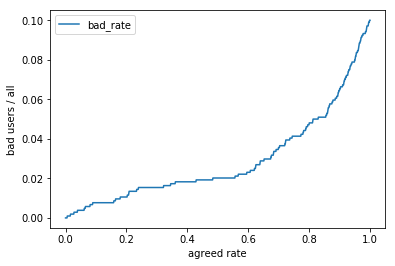

In [567]:
ax = plt.subplot()
df_pred.plot('agree_rate', 'bad_rate',  ax=ax)
ax.set_xlabel('agreed rate')
ax.set_ylabel('bad users / all')

Text(0,0.5,'bad_users/agreed_users')

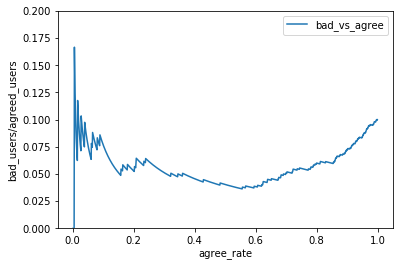

In [568]:
ax = plt.subplot()
df_pred['bad_vs_agree'] = df_pred['y_test_cumsum']/df_pred.index
df_pred.plot('agree_rate', 'bad_vs_agree', ax=ax, ylim=[0, 0.2])
ax.set_xlabel('agree_rate')
ax.set_ylabel('bad_users/agreed_users')

In [569]:
roc_auc_score(y_test, pred)

0.7435435157790927